In [1]:
using DataFrames, CSV, CategoricalArrays
using Statistics, LinearAlgebra, Random
using Plots, ProgressBars

# Boston Data

In [2]:
    filename = "../Datasets/Boston.csv"
    data = DataFrame(CSV.File(filename))
    df = copy(data)
    dropmissing!(df)
    ndf = names(df)

14-element Vector{String}:
 "crim"
 "zn"
 "indus"
 "chas"
 "nox"
 "rm"
 "age"
 "dis"
 "rad"
 "tax"
 "ptratio"
 "black"
 "lstat"
 "medv"

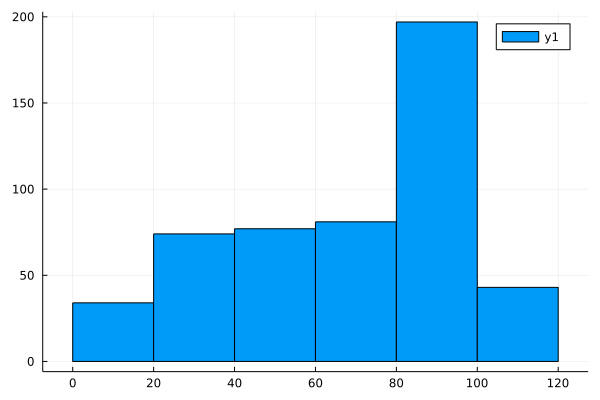

In [3]:
    name_of_y = :medv
    names_of_x =  ["rm", "lstat", "dis"] # 3:8
    names_of_z =[:age] # :pos
    dfy = df[!, name_of_y]
    dfX = df[!, names_of_x]
    dfZ = df[!, names_of_z]

    X, Z, y = Array(dfX), Array(dfZ), Array(dfy)
histogram(Z)

# QGPLSIM fitting

In [4]:
include("./src/qgplsim.ji")
include("./src/supportFunctions.ji")
include("RealWorldData.ji")

mc_simu (generic function with 3 methods)

In [5]:
Xa, Za, ya = boston()
X = scaler(Xa, 1)
y = ya ./(maximum(ya) - minimum(ya)) 
y = y .- mean(y)
Z, zmap = categ_binary(Za) # [:, 1]
categ, index = collection(Z)
n,p = size(X)  
n,q = size(Z)
zmap

1-element Vector{Any}:
 Dict{Any, Any}(0 => [0, 0], 2 => [0, 1], 1 => [1, 0])

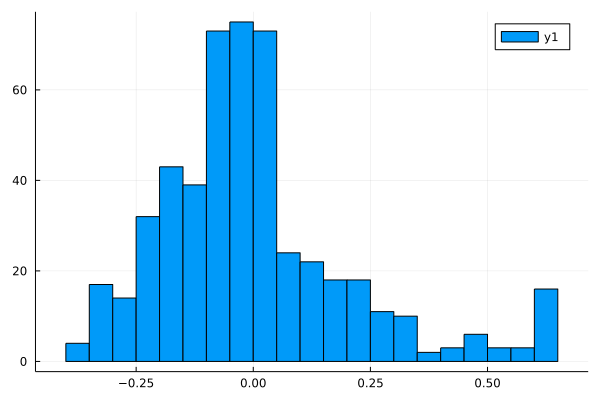

In [6]:
histogram(y)

alpha => [0.0498, -0.0714, 0.0375]
theta => [0.3577, -0.2264, -0.906]
gamma => [-0.4352, -1.2578]
beta => [-0.1749, 0.0605]


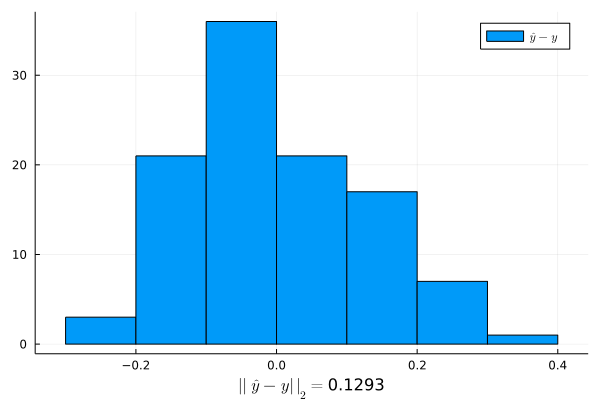

In [7]:
tau = [0.5]
dy = 0
method = "qr" # mean for mean regression, optim and mm for qr regression
ntrain = 400
ntest = n - ntrain

indr, indt = get_train_index(Z, ntrain)
# shuffle!(indt)

Xr = X[indr, :]
yr = y[indr] 
Zr = Z[indr, :]

Xt = X[indt, :]
yt = y[indt]  
Zt = Z[indt, :]
# Zr = Zr .* 0
# Zt = Zt .* 0
width_exp = -0.2
qsmodel = qgplsim.model(Xr, Zr, yr, tau, width_exp)
qgplsim.estimator(qsmodel)
qgplsim.print_model(qsmodel)
vv = Xt * qsmodel.theta
ylx = Xt * qsmodel.alpha
ylz = Zt * qsmodel.beta
yp = qgplsim.predict(qsmodel, Xt, Zt, dy, method) + ylx  + ylz

using LaTeXStrings
e = round(rmsd(yp, yt), digits = 4)
str = string(L"||\hat{y} - y||_2 = ", "$e")
histogram(yt .- yp, label = L"\hat{y} - y")
xlabel!(str)

In [42]:
using Base.Threads
n_pt = 25
nmc = n_pt*Threads.nthreads()
bias = zeros(nmc)


Theta = zeros(nmc, p)
Gamma = zeros(nmc, q)
Alpha = zeros(nmc, p)
Beta  = zeros(nmc, q)

width_exp = -0.12


@threads for i in 1:Threads.nthreads()
    for j in 1:n_pt
    t = (i - 1)*n_pt + j 

indr, indt = get_train_index(Z, ntrain)
# shuffle!(indt)

    Xr = X[indr, :]
    yr = y[indr] 
    Zr = Z[indr, :]

    Xt = X[indt, :]
    yt = y[indt]  
    Zt = Z[indt, :]
    # Zr = Zr .* 0
    # Zt = Zt .* 0
    qsmodel = qgplsim.model(Xr, Zr, yr, tau, width_exp)
    qgplsim.estimator(qsmodel)
    # qsmodel1 = qgplsim.model(Xr, Zr, yr, 0.1)
    # qsmodel9 = qgplsim.model(Xr, Zr, yr, 0.9)
    # @time qgplsim.estimator(qsmodel1)
    # @time qgplsim.estimator(qsmodel9)
    
    Theta[t, :], Gamma[t, :],
    Alpha[t, :], Beta[t, :] = qsmodel.theta, qsmodel.gamma, qsmodel.alpha, qsmodel.beta
        
    vv = Xt * qsmodel.theta
    ylx = Xt * qsmodel.alpha
    ylz = Zt * qsmodel.beta
    yp = qgplsim.predict(qsmodel, Xt, Zt, dy) + ylx  + ylz
    # bias = rho.(yt - yp, tau)./2
    bias[t] = rmsd(yp, yt)
    end
end

In [43]:
mean(Theta, dims = 1)

1×3 Matrix{Float64}:
 0.187992  -0.00653958  -0.421188

In [44]:
mean(Alpha, dims = 1)

1×3 Matrix{Float64}:
 0.0645448  -0.0665419  0.00975692

In [45]:
mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 0.0159166  -0.0157017

In [46]:
mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 -0.115444  -0.210202

In [47]:
mean(bias)

0.14233747539216016

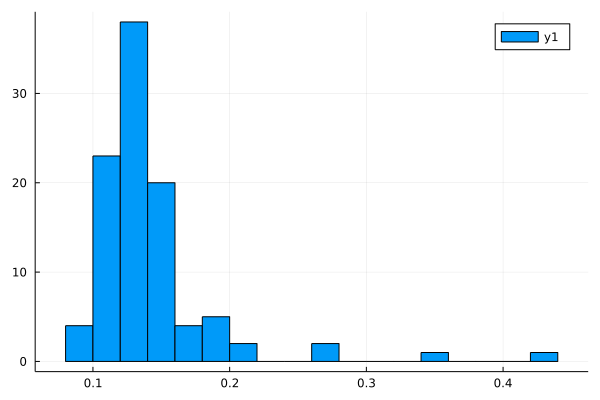

In [49]:
histogram(bias)